# Ethnicity and Excess Deaths

Comparing Excess deaths at local authortiy level with other socio-economic indicators. 

In [1]:
import sys
sys.path.insert(0, '../src/data')
import pandas as pd
import geopandas as gpd
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import bame_datastore
from scipy.stats import spearmanr
import numpy as np

Found local clean copy of Local_Authority_Districts__December_2017__Boundaries_in_the_UK__WGS84_
Found local clean copy of fbook_covid_cases
Found local clean copy of BAME_report_cases
Found local clean copy of BAME_report_deaths
Found local clean copy of bame_excess_deaths
Found local clean copy of ons_deaths
Found local clean copy of excess_deaths_data_grp
Found local clean copy of excess_deaths_data_loc
Found local clean copy of ethnicity_2011
Found local clean copy of furlough_data
Found local clean copy of key_workers
Found local clean copy of deprivation_data
Found local clean copy of population_est_data


In [2]:
bame_datastore.lib

{'mortality': ['excess_deaths_grp',
  'excess_deaths_loc',
  'fbook_covid_data',
  'bame_rpt_deaths',
  'bame_rpt_excess_deaths',
  'ons_deaths'],
 'explanatory': ['ethnicity_data',
  'bame_rpt_cases',
  'furlough_data',
  'key_workers',
  'deprivation',
  'pop_est'],
 'other': ['lad_geog']}

In [3]:
#importing and cleaning our main dataset
excess_deaths_df = bame_datastore.excess_deaths_grp.df # import excess deaths data
ethnicity_df = bame_datastore.ethnicity_data.df # import 2011 census data
ethnicity_list = ethnicity_df.columns[2:] 
df = excess_deaths_df.join(ethnicity_df) # join by local authority

# Adding Population
pop_df = bame_datastore.pop_est.df.copy() # import 2020 population estimates
pop_df = pop_df.reset_index().set_index("Code")
cols_to_sum = pop_df.columns[68:] # gather 65+ columns
pop_df['total_65+'] = pop_df[cols_to_sum].sum(axis=1)  # create 65+ column
pop_df["pct_65+"] = pop_df["total_65+"]/ pop_df["All ages"]
df = df.join(pop_df.drop(columns = pop_df.columns[3:-1])) # drop the rest
df.rename(columns={"All ages": "total_pop"}, inplace=True)

df["excess_deaths_per_thsd"] = (df["allexcess"]/df["total_pop"])*1000 # normalise deaths by population
df = df.drop(columns = ["Geography_name", "Denominator", "Name", "Geography1", "pop"])
df = df.dropna()

In [4]:
target_var = "allexcess"
df

,name,week,deaths.1519,AllCause.20,COVID.20,Other.20,allexcess,excessrate_sum,othexcess_sum,excessrate_mean,othexcess_mean,COVIDrate,Asian,Black,Mixed,Other,White,total_pop,pct_65+,excess_deaths_per_thsd
code,,,,,,,,,,,,,,,,,,,,
E06000001,Hartlepool,25,1025.2,600.0,108.0,492.0,35.6,38.180219,-72.4,0.610988,-1.066667,1.754964,1.42,0.18,0.60,0.11,97.69,93663.0,0.194292,0.380086
E06000002,Middlesbrough,25,1466.4,967.0,205.0,762.0,166.2,118.253940,-38.8,1.808975,-0.533333,2.188450,7.78,1.25,1.71,1.08,88.18,140980.0,0.163839,1.178891
E06000003,Redcar and Cleveland,25,1563.2,929.0,133.0,796.0,64.6,47.250545,-68.4,0.853338,-0.833333,1.462865,0.64,0.09,0.63,0.10,98.54,137150.0,0.226278,0.471017
E06000004,Stockton-on-Tees,25,1904.0,1039.0,149.0,890.0,3.2,1.622611,-145.8,0.282728,-1.563636,1.075594,3.46,0.59,1.04,0.29,94.62,197348.0,0.184562,0.016215
E06000005,Darlington,25,1147.8,703.0,90.0,613.0,76.4,71.692660,-13.6,1.151655,-0.106061,1.251181,2.09,0.34,1.09,0.25,96.24,106803.0,0.205397,0.715336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E09000029,Sutton,25,1482.6,968.0,179.0,789.0,139.2,68.060139,-39.8,1.160116,-0.309091,1.311242,11.59,4.80,3.75,1.27,78.60,206349.0,0.153245,0.674585
E09000030,Tower Hamlets,25,1067.2,675.0,188.0,487.0,102.6,32.294109,-85.4,0.593270,-0.933333,0.887044,41.13,7.33,4.08,2.28,45.19,324745.0,0.064232,0.315940
E09000031,Waltham Forest,25,1424.0,943.0,248.0,695.0,154.0,55.655945,-94.0,1.124728,-0.645455,1.357996,21.06,17.34,5.33,4.07,52.20,276983.0,0.108238,0.555991


# Local Authority Picture

Comparing local authority ethnic make up with excess death statistics

In [5]:
def reg_plot(df, cov_death_col, title = False):
    """Takes in DataFrame and name of covid death column"""
    fig, ax = plt.subplots(figsize=(20,10))

    corr_capture = {}
    for i in ethnicity_list: #itterate throught the ethnicities
        correlation = df[cov_death_col].corr(df[i])
        corr_capture[i] = correlation

        ax = sns.regplot(x=i, y=cov_death_col, data=df, label=i)

    ax.legend()
    plt.legend(loc='upper right')
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'Relationship between {cov_death_col} and ethnicity broken down by Local Authority District')
    ax.set_xlabel('% of local population in this ethnic group - 2011 Census')
    ax.set_ylabel('number of excess deaths in the local authority district')

    plt.savefig(f"../reports/figures/regplot{cov_death_col}.png")

<Figure size 1368x1080 with 0 Axes>

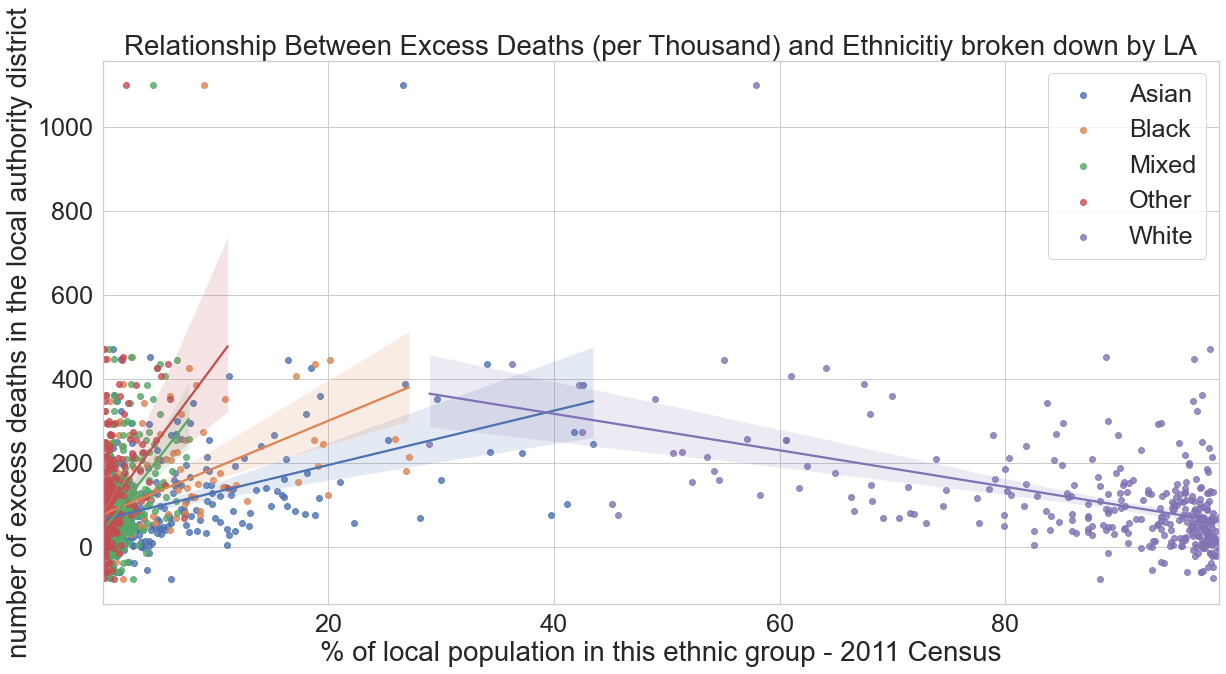

In [20]:
sns.set(style="whitegrid", font_scale=2.3)
plt.figure(figsize=(19, 15))


reg_plot(df, target_var, 
         title= "Relationship Between Excess Deaths (per Thousand) and Ethnicitiy broken down by LA")

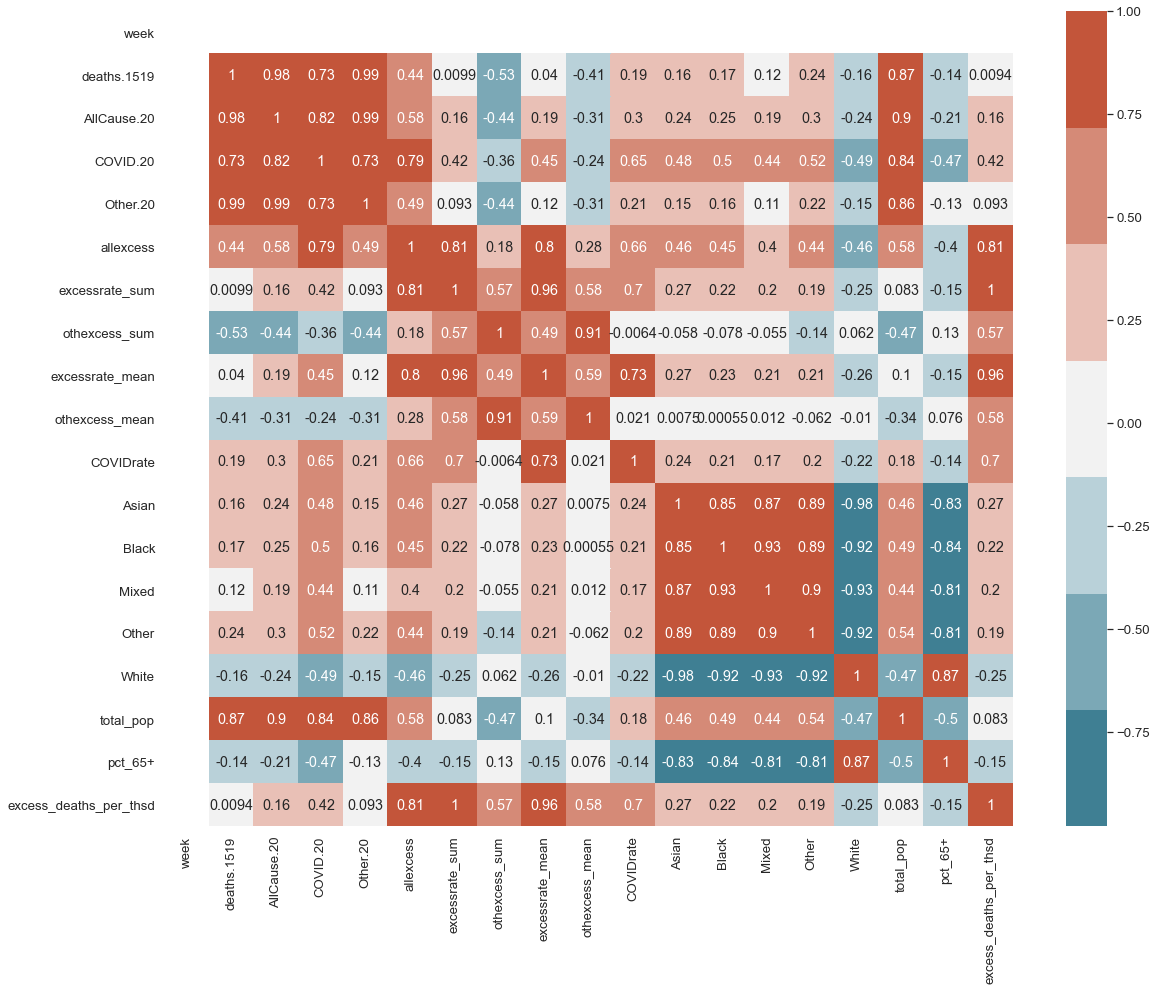

In [7]:
sns.set(style="whitegrid", font_scale=1.2)
#correlation matrix of relevant variables
plt.figure(figsize=(19, 15))
corrMatrix = df.corr(method="spearman")
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
# plt.show()
plt.savefig("../reports/figures/corrmat.png")

## Deprivation and Furlough and Density

Calculate population density of local authorities, using the [size of polygons](https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas)
cross refrencing with the [GLA density estimates](https://data.gov.uk/dataset/a76f46f9-c10b-4fe7-82f6-aa928471fcd1/land-area-and-population-density-ward-and-borough).

In [8]:
# Adding Furlough
furlough_df = df.join(bame_datastore.furlough_data.df.drop(columns="Area Name"))
furlough_df["furloughed_pop"] = furlough_df["total_furloughed"]/ furlough_df["total_pop"]
# furlough_df = furlough_df.drop(columns=['deaths_all', 'deaths_covid', 'total_pop', "total_furloughed"])

In [9]:
# Adding Deprivation measures
deprv_df = bame_datastore.deprivation.df.copy()
deprv_df = deprv_df.drop(columns=['IMD_decile_avg', 'IMD_decile_std', "IMD_rank_std"])
dep_fur_df = furlough_df.join(deprv_df)

In [10]:
# Adding Population Density

la_gdf = bame_datastore.lad_geog.gdf.copy()
la_gdf = la_gdf.to_crs({'init': 'epsg:5243'}) # change projection to get the area 
la_gdf["area"] = la_gdf['geometry'].area/ 10**6 # area in square km

dep_fur_df

dense_df = dep_fur_df.join(la_gdf.set_index("lad17cd"))
dense_df["pop_density"] = dense_df["total_pop"]/dense_df["area"]
dense_df = dense_df.drop(columns=["lad17nm", "bng_n",'objectid', 'lad17nmw', 'bng_e', 
                                  'st_areashape','st_lengthshape',"long","lat"])



/Users/yusufsohoye/pythoncode/covid_bame/venv/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [11]:
target_var

'allexcess'

In [12]:
dense_df_plot = dense_df.drop(columns=[ "area", "total_pop", 'total_furloughed', 
                                       'Local Authority District name (2019)','geometry',])


dense_df_plot = dense_df_plot[[target_var,'pop_density','pct_65+','furloughed_pop', 'IMD_rank_avg',
                                'Asian', 'Black', 'Mixed', 'Other','White']]

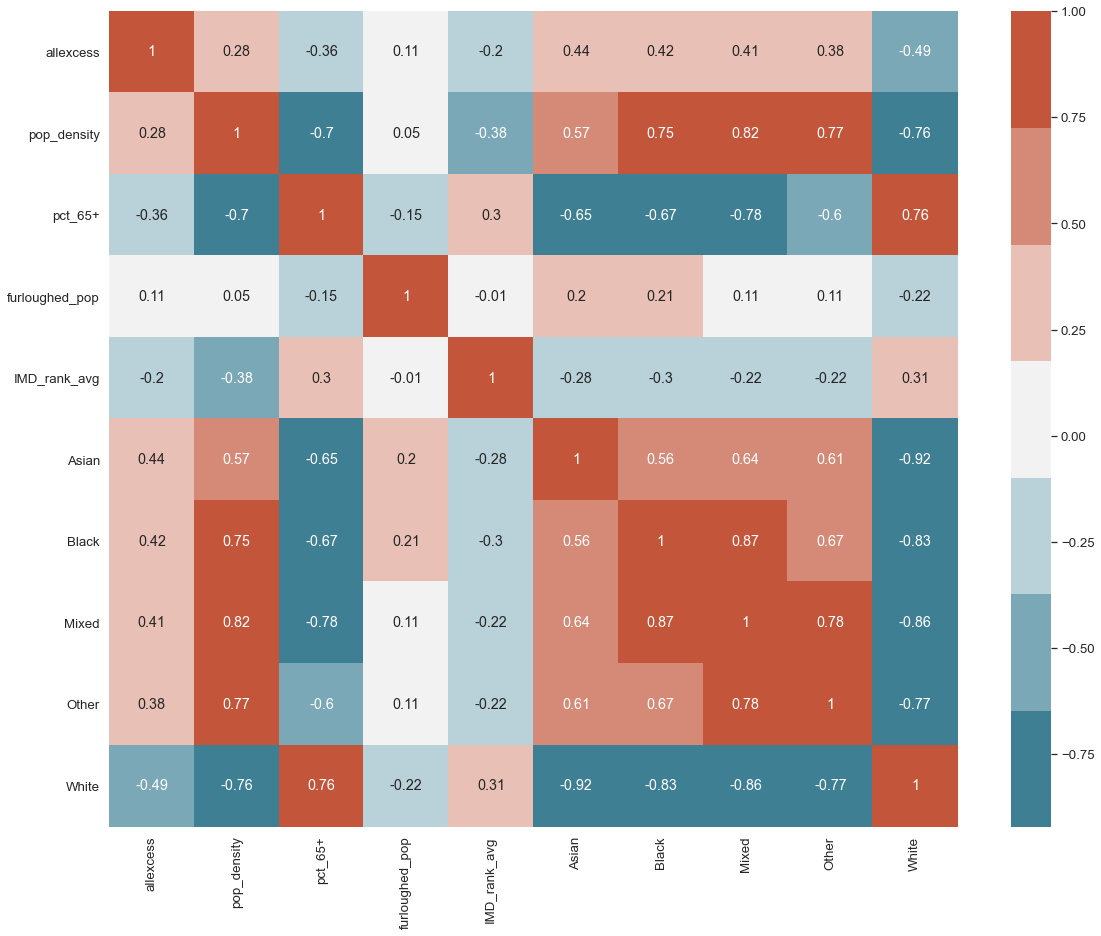

In [13]:
# Spearmans Corrleation
rho = dense_df_plot.corr().round(2)
pval = dense_df_plot.corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))


sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(19, 15))
corrMatrix = dense_df_plot.corr(method="spearman")
sns.heatmap(rho, annot=True, cmap=sns.diverging_palette(220, 20, n=7))
plt.savefig("../reports/figures/local_attr_cormat.png")

In [14]:
# Significance / p values

sig_df = rho.astype(str) + p
sig_df.to_csv(("../reports/figures/corr_pvals.csv"))

# Regression
Caution advised

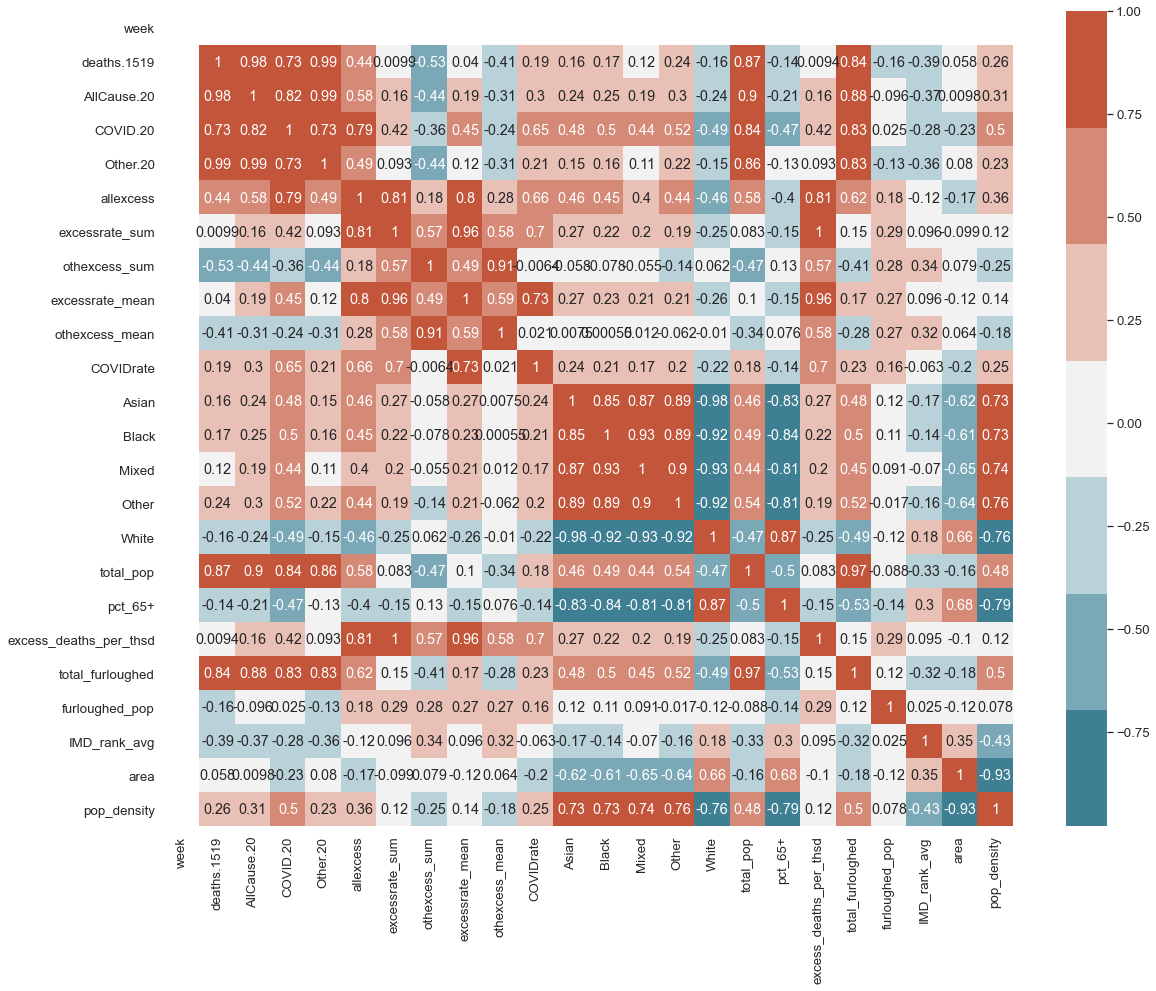

In [15]:
dense_df.to_csv("../data/processed/dense_df.csv")

# Create master df
master_df = dense_df


# master_df = master_df.drop(columns=["deaths_all", "deaths_covid", "area", "total_pop"])
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(19, 15))
corrMatrix = master_df.corr(method="spearman")
sns.heatmap(corrMatrix, annot=True, cmap=sns.diverging_palette(220, 20, n=7))

In [16]:
reg_all = master_df.reset_index().drop(columns=["index", "name", "week", "geometry", 
                                              "AllCause.20", "COVID.20", "Other.20", 
                                               "excessrate_sum","othexcess_sum","excessrate_mean", 
                                              "othexcess_mean", "COVIDrate", "excess_deaths_per_thsd",
                                                "Local Authority District name (2019)"])
X = reg_all.drop(columns=[target_var])
y = reg_all[target_var]
res = sm.OLS(y, X.astype(float), missing='drop').fit()

res.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              allexcess   R-squared (uncentered):                   0.819
Model:                            OLS   Adj. R-squared (uncentered):              0.811
Method:                 Least Squares   F-statistic:                              101.2
Date:                Wed, 22 Jul 2020   Prob (F-statistic):                    1.74e-99
Time:                        23:18:37   Log-Likelihood:                         -1700.8
No. Observations:                 303   AIC:                                      3428.
Df Residuals:                     290   BIC:                                      3476.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
deaths.1519          0.0726      0.021      3.453      0.001       0.031       0.114
Asian               -0.8591      1.030     -0.834      0.405      -2.886       1.168
Black                5.3376      2.296      2.325      0.021       0.819       9.856
Mixed              -10.1698      8.467     -1.201      0.231     -26.835       6.496
Other               18.6617      7.623      2.448      0.015       3.659      33.664
White               -3.4167      0.799     -4.277      0.000      -4.989      -1.844
total_pop            0.0006      0.000      1.611      0.108      -0.000       0.001
pct_65+            144.6638    167.836      0.862      0.389    -185.667     474.994
total_furloughed    -0.0047      0.003     -1.448      0.149      -0.011       0.002
furloughed_pop    1820.0382    587.968      3.095      0.002     662.813    2977.264
IMD_rank_avg         0.0036      0.001      3.522      0.000       0.002       0.006
area                -0.0225      0.009     -2.461      0.014      -0.040      -0.005
pop_density         -0.0088      0.003     -2.753      0.006      -0.015      -0.003
==============================================================================
Omnibus:                       24.022   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.734
Skew:                          -0.214   Prob(JB):                     1.32e-17
Kurtosis:                       5.444   Cond. No.                     3.23e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.23e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""